# Frozen Lake 
4/20/21
- Value Iteration
- Policy Iteration
- Q Learning
- Try big and small space

 Reference code:
https://github.com/luclement/ml-assignment4/blob/master/frozen_lake.ipynb
https://medium.com/@m.alzantot/deep-reinforcement-learning-demysitifed-episode-2-policy-iteration-value-iteration-and-q-978f9e89ddaa#:~:text=Value%20iteration%20computes%20the%20optimal,converge%20to%20the%20optimal%20values.

In [1]:
import numpy as np
import gym
from hiive.mdptoolbox import example, mdp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## 1. Helper Functions

In [2]:
# credit https://github.com/wesley-smith/CS7641-assignment-4/blob/f3d86e37504dda563f65b3267610a30f09d01c77/helpers.py
# credit https://github.com/luclement/ml-assignment4/blob/master/frozen_lake.ipynb
TERM_STATE_MAP = {"4x4": [5, 7, 11, 12], "8x8": [19, 29, 35, 41, 42, 46, 49, 52, 54, 59], "50x50":[]}
GOAL_STATE_MAP = {"4x4": [15], "8x8": [63], "50x50":[2499]}
cmap = 'cool'
def visualize_env(env, name, title=None):
    shape = env.desc.shape
    M = shape[0]
    N = shape[1]
    arr = np.zeros(shape)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                arr[i, j] = 0.25
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                arr[i, j] = 1.0
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(arr, cmap=cmap)
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)

    for i in range(M):
        for j in range(N):
            if (i, j) == (0, 0):
                ax.text(j, i, 'S', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in TERM_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k', size=18)
            else:
                ax.text(j, i, 'F', ha='center', va='center', color='k', size=18)
    fig.tight_layout()
    if title:
        ax.set_title(title)
    plt.show()

def visualize_policy(policy, shape, name, title=None):
    M = shape[0]
    N = shape[1]
    actions = np.asarray(policy).reshape(shape)
    mapping = {
        0: '←',
        1: '↓',
        2: '→',
        3: '↑'
    }
    arr = np.zeros(shape)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                arr[i, j] = 0.25
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                arr[i, j] = 1.0
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(arr, cmap=cmap)
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)

    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k', size=18)
            else:
                ax.text(j, i, mapping[actions[i, j]], ha='center', va='center', color='k', size=18)
    # fig.tight_layout()
    if title:
        ax.set_title(title)
    plt.show()

def visualize_value(V, shape, name, title=None):
    V = np.asarray(V)
    M = shape[0]
    N = shape[1]
    fig, ax = plt.subplots(figsize=(12,12))
    arr = V.reshape(shape)
    im = ax.imshow(arr, cmap=cmap)
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k')
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k')
            else:
                ax.text(j, i, '%.2f' % (arr[i, j]), ha='center', va='center', color='k')
    # fig.tight_layout()
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('State-value estimate', rotation=-90, va="bottom")
    if title:
        ax.set_title(title)
    plt.show()

In [3]:
# Unpacked from gym.unwrapped.P is a list of states. Each state has a dictionary [0,1,2,3]. Each dictionary
# contains a 4 part tuple [probability(?),new_state,reward,finished]
def getRewardProb(env, sz):
    sz = int(sz**2)
    r = np.zeros((4,sz,sz))
    p = np.zeros((4,sz,sz))
    envP = env.unwrapped.P
    for state in envP:
        for action in envP[state]:
            transitions = envP[state][action]
            for t_idx in range((len(transitions))):
                new_state = transitions[t_idx][1]
                trans_prob = transitions[t_idx][0]
                reward = transitions[t_idx][2]
                p[action][state][new_state] += trans_prob
                r[action][state][new_state] += reward
            p[action,state,:] /= np.sum(p[action,state,:])
    return r, p

Andrew's GYM v2 :)


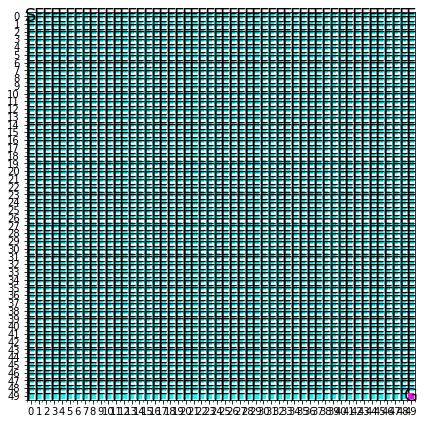

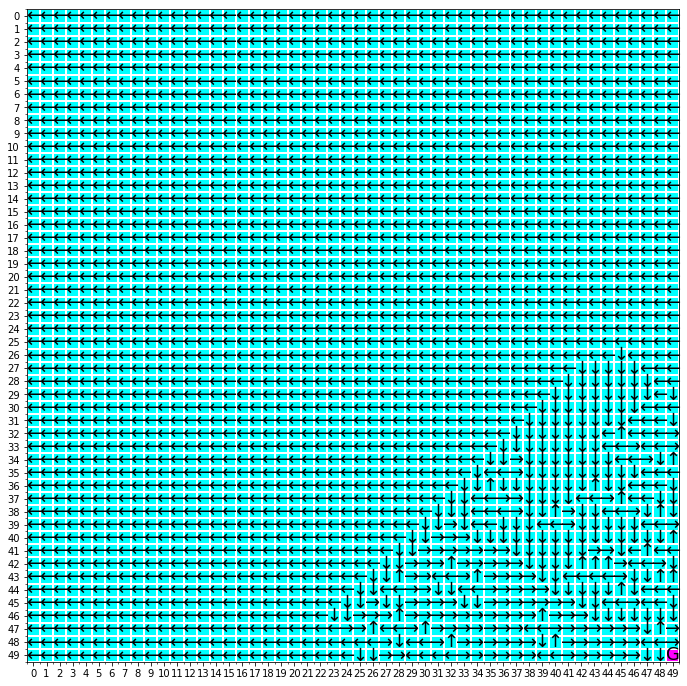

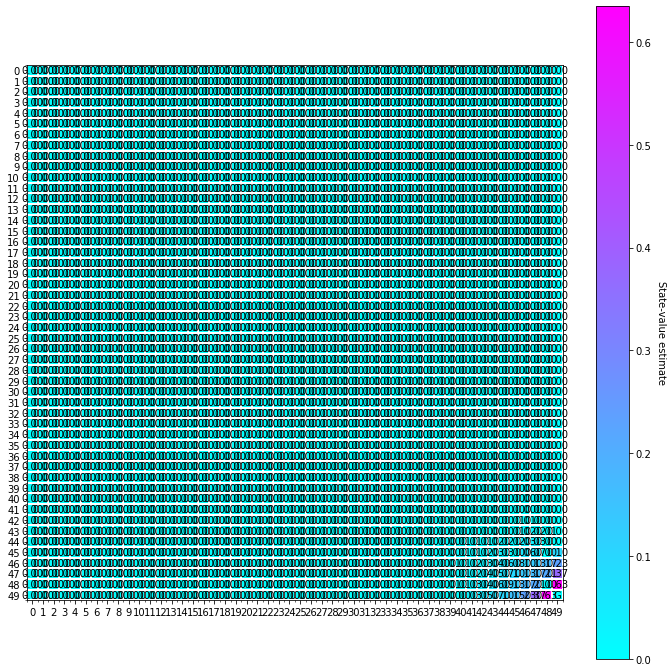

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [4]:
s = 50
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v0", map_name=None, desc=None)
env.reset()
visualize_env(env, opt)
r, p = getRewardProb(env, s)
vi = mdp.ValueIteration(p, r, 0.9, max_iter=10000)
vi.run()
visualize_policy(vi.policy, sz, opt)
visualize_value(vi.V, sz, opt)
print(vi.policy)
print(vi.V)

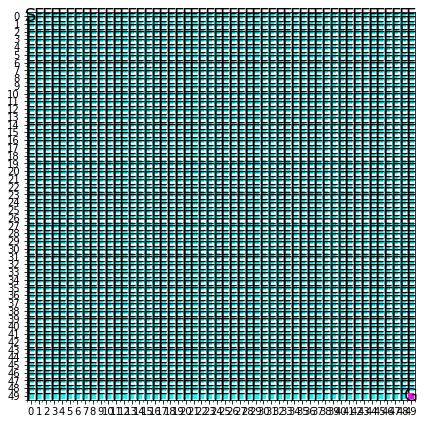

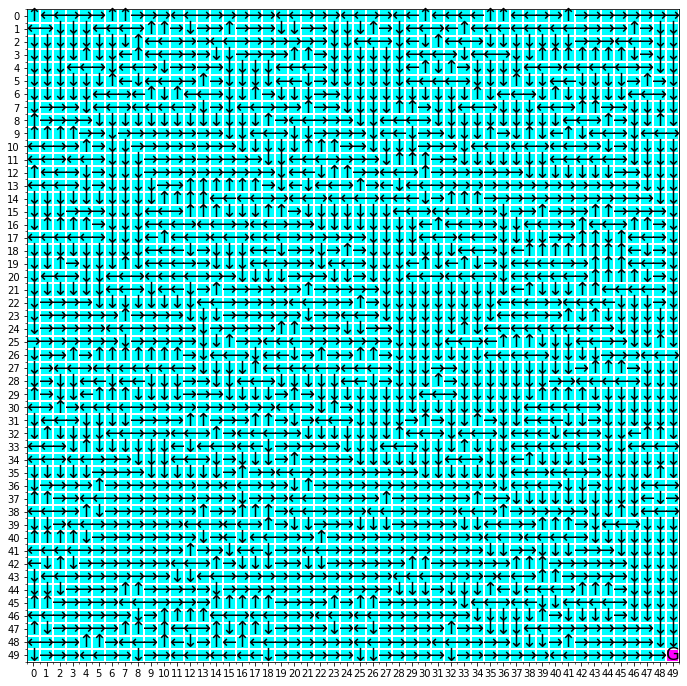

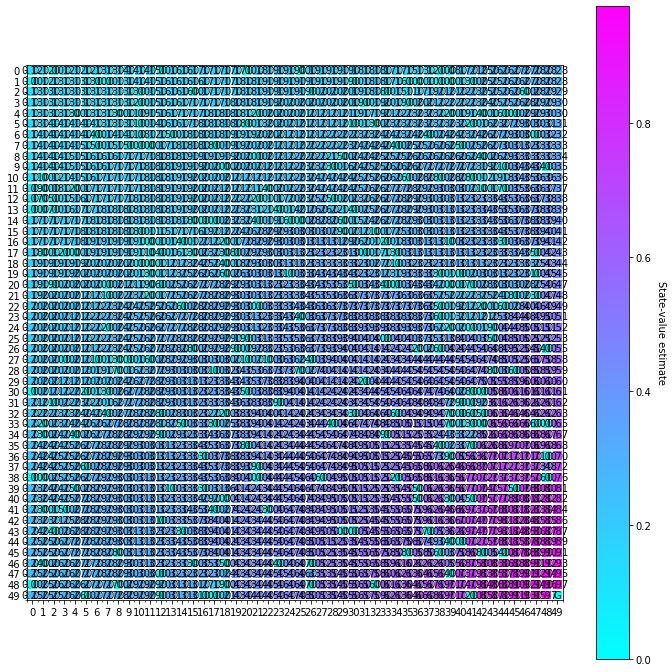

(3, 0, 0, 2, 2, 2, 3, 3, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 3, 0, 0, 0, 0, 3, 3, 0, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 1, 0, 0, 0, 2, 3, 3, 2, 1, 2, 2, 3, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 3, 2, 1, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 2, 1, 0, 1, 3, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 3, 0, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 3, 3, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0, 0, 2, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 2, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 0, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 0, 3, 1, 3, 2, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 0, 0, 2, 2, 3, 2, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 3, 1, 1, 0, 0, 1, 1, 1, 1, 2, 3, 2, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 3, 1, 3, 0, 0, 2, 1, 1, 3, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [5]:
s = 50
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v0", map_name=None, desc=None)
env.reset()
visualize_env(env, opt)
r, p = getRewardProb(env, s)
vi = mdp.ValueIteration(p, r, 0.995, max_iter=10000)
vi.run()
visualize_policy(vi.policy, sz, opt)
visualize_value(vi.V, sz, opt)
print(vi.policy)
print(vi.V)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


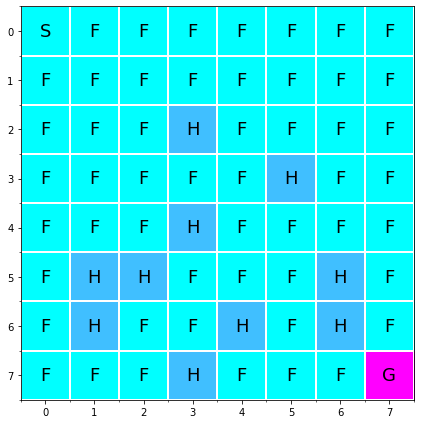

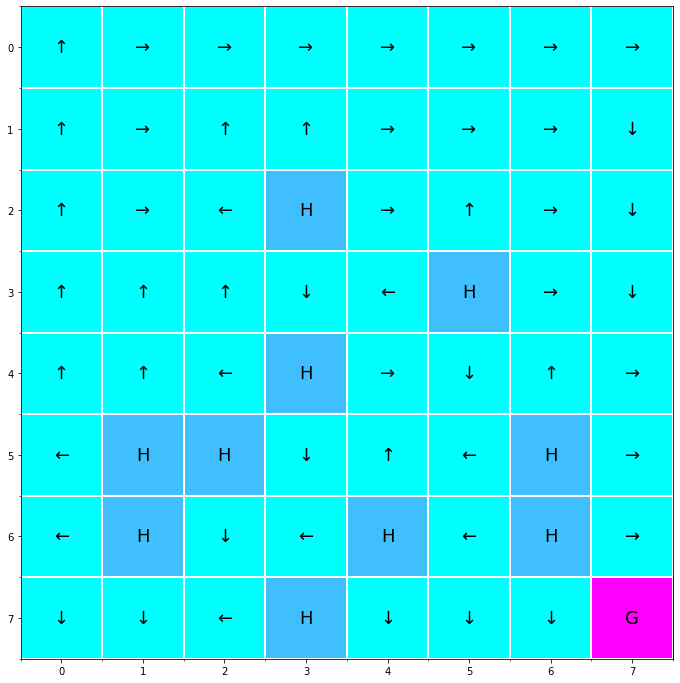

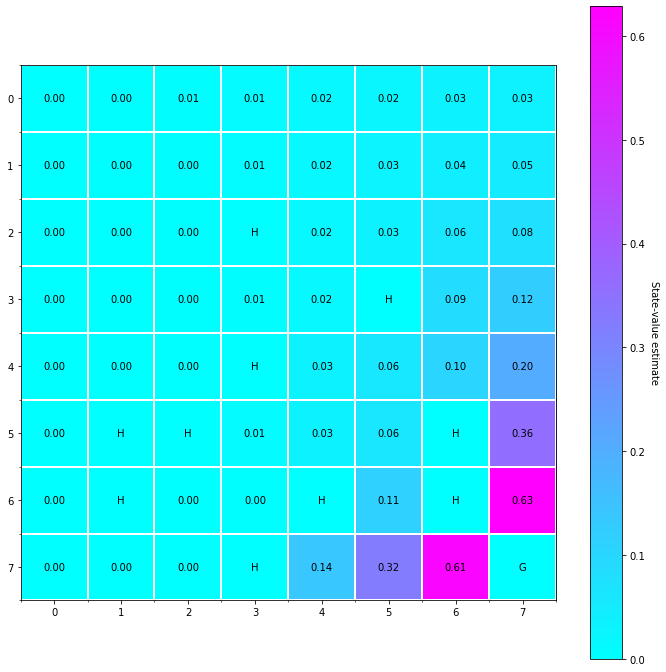

(3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 1, 3, 2, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 1, 3, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 1, 0)
(0.0016222239566742473, 0.003060767917967338, 0.005794696120726524, 0.010391772523762477, 0.017096445085483743, 0.024184217897011896, 0.031305405198300065, 0.034807000637929984, 0.0014614164657766957, 0.0025998234270686914, 0.00491158820225451, 0.009528857060098674, 0.018569242048914848, 0.02824681107297098, 0.04145082033811706, 0.04961360828623488, 0.00110767183800537, 0.0017479003053684666, 0.002534743663058876, 0.0, 0.019251888940225094, 0.031535518612617976, 0.06038509407787975, 0.07740832679314802, 0.0008892444937213366, 0.0014289582948647493, 0.0026514428762168386, 0.005501707812890226, 0.016324897609164078, 0.0, 0.08538043726900817, 0.12312206063017188, 0.0005936070916375847, 0.0007957864730272987, 0.0009520707606779981, 0.0, 0.03105538035855836, 0.058199567021159915, 0.10375840184356261, 

In [6]:
s = 8
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v0", map_name=opt)
env.reset()
env.render()
visualize_env(env, opt)
if s == 4:
    r, p = getRewardProb(env, 4)
else:
    r, p = getRewardProb(env, 8)
vi = mdp.ValueIteration(p, r, 0.9, max_iter=10000)
vi.run()
visualize_policy(vi.policy, sz, opt)
visualize_value(vi.V, sz, opt)
print(vi.policy)
print(vi.V)

## 2. Value Iteration

In [6]:
# Error is defined at line 1180 of:
# https://github.com/hiive/hiivemdptoolbox/blob/master/hiive/mdptoolbox/mdp.py
# It's the change in Q, AKA dQ
def valueIterateGraph(p, r, value_iterate=True):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    iterations = []
    gammas = list(np.arange(0.5,1,0.04))
    print(gammas)
    for gamma in gammas:
        if value_iterate:
            vi = mdp.ValueIteration(p, r, gamma)
        else:
            vi = mdp.PolicyIteration(p, r, gamma, max_iter=50)
        vi.run()
        vi.run_stats
        iterations.append(list(range(1,len(vi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in vi.run_stats])
        mean_vs.append([el['Mean V'] for el in vi.run_stats])
        errors.append([el['Error'] for el in vi.run_stats])
        rewards.append([el['Reward'] for el in vi.run_stats])

    f, ax = plt.subplots(2,2, figsize=(15,12))
    ax[0][0].set_title("Max V", fontsize=16)
    for i in range(len(max_vs)):
        ax[0][0].plot(iterations[i], max_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][0].legend()
    ax[0][0].set_xlabel("# Iterations")

    ax[0][1].set_title("Mean V", fontsize=16)
    for i in range(len(mean_vs)):
        ax[0][1].plot(iterations[i], mean_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][1].legend()
    ax[0][1].set_xlabel("# Iterations")

    ax[1][0].set_title("Error", fontsize=16)
    for i in range(len(errors)):
        ax[1][0].plot(iterations[i], errors[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][0].legend()
    ax[1][0].set_xlabel("# Iterations")

    ax[1][1].set_title("Reward", fontsize=16)
    for i in range(len(max_vs)):
        ax[1][1].plot(iterations[i], rewards[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][1].legend()
    ax[1][1].set_xlabel("# Iterations")
    plt.plot()

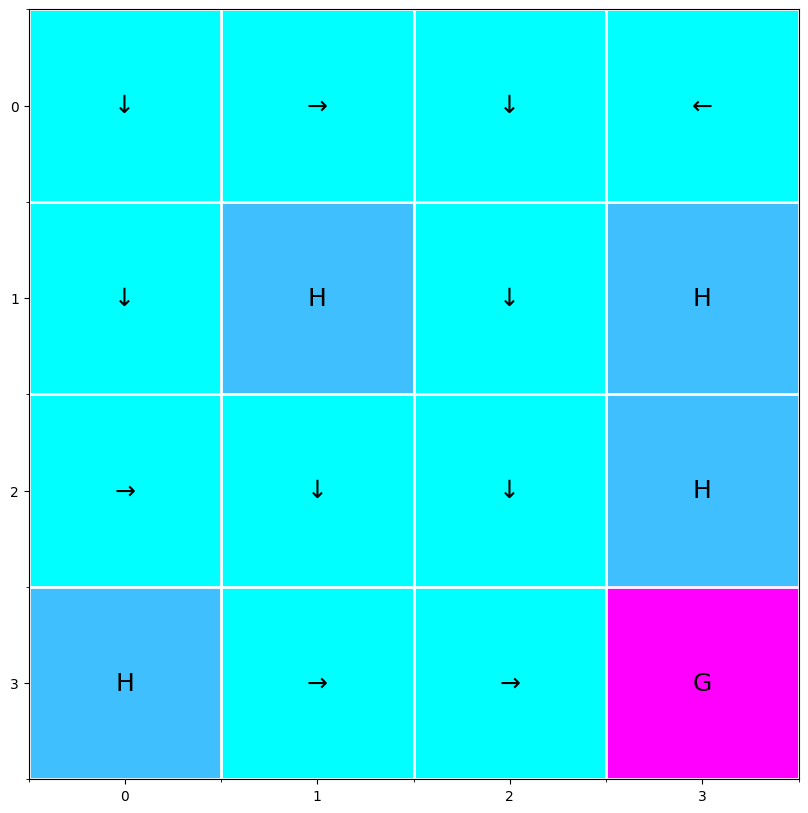

[0.5, 0.54, 0.5800000000000001, 0.6200000000000001, 0.6600000000000001, 0.7000000000000002, 0.7400000000000002, 0.7800000000000002, 0.8200000000000003, 0.8600000000000003, 0.9000000000000004, 0.9400000000000004, 0.9800000000000004]
0.13468384742736816


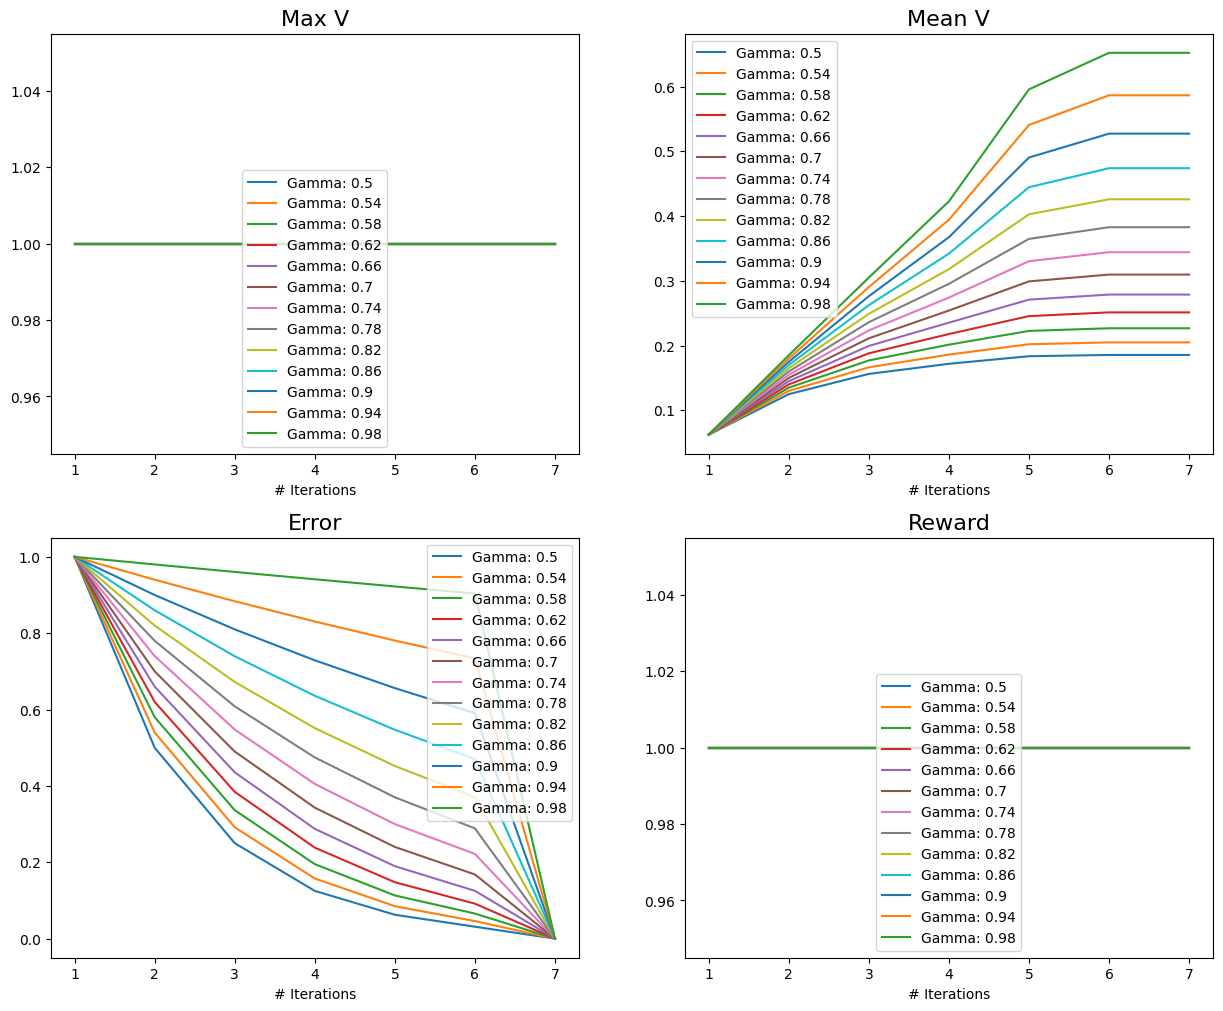

In [7]:
from time import time
tic = time()
env = gym.make("FrozenLake-v0", is_slippery=False)
r, p = getRewardProb(env,4)
vi = mdp.ValueIteration(p, r, 0.9, max_iter=10000)
vi.run()
visualize_policy(vi.policy, (4,4), "4x4")
valueIterateGraph(p, r)
print(time()-tic)

In [8]:
tic = time()
env = gym.make("FrozenLake-v0", is_slippery=True, map_name=None, desc=None)
r, p = getRewardProb(env, 50)
vi = mdp.ValueIteration(p, r, 0.99, max_iter=10000)
vi.run()
visualize_policy(vi.policy, (50,50), "50x50")
valueIterateGraph(p, r)
print(time()-tic)

StochasticError: 'PyMDPToolbox - The transition probability matrix is not stochastic.'

In [10]:
def runEpisodes(episodes, gamma, sz, max_iter=5000):
    total_rewards = []
    total_successes = 0
    for episode in tqdm(range(episodes)):
        if sz == 8:
            env = gym.make("FrozenLake-v0", is_slippery=True, map_name="8x8")
            env.reset()
            r, p = getRewardProb(env, 8)
        elif sz == 4:
            env = gym.make("FrozenLake-v0", is_slippery=True, map_name="4x4")
            env.reset()
            r, p = getRewardProb(env, 4)
        elif sz == 50:
            env = gym.make("FrozenLake-v0", is_slippery=True, map_name=None, desc=None)
            env.reset()
            r, p = getRewardProb(env, 50)
        vi = mdp.ValueIteration(p, r, gamma, max_iter=max_iter)
        vi.run()
        done = False
        state = 0
        policy = vi.policy
        total_reward = 0
        t = 0
        while not (env.desc[state//sz][state%sz]==b'H' or env.desc[state//sz][state%sz]==b'G') and t<3000:
            action = policy[state]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if (env.desc[state//sz][state%sz]==b'H' or env.desc[state//sz][state%sz]==b'G'):
                if reward == 1:
                    total_successes += 1
                break
            t += 1
        total_rewards.append(total_reward)
    return total_successes

In [11]:
gammas = [el/100 for el in list(range(1, 100, 1))]
success_rates4 = []
for gamma in tqdm(gammas):
    episodes = 10
    total_successes = runEpisodes(episodes = episodes, gamma=gamma, sz=4)
    success_rates4.append(np.round(total_successes/episodes, 3))
print(success_rates4)

100%|██████████| 99/99 [00:01<00:00, 79.71it/s]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.5, 0.3, 0.1, 0.3, 0.3, 0.4, 0.3, 0.2, 0.1, 0.5, 0.1, 0.4, 0.2, 0.1, 0.0, 0.2, 0.2, 0.1, 0.3, 0.2, 0.3, 0.6, 0.3, 0.6, 0.3, 0.6, 0.5, 0.3, 0.4, 0.4, 0.7, 0.2, 0.3, 0.3, 0.4, 0.7, 0.3, 0.2, 0.4, 0.4, 0.3, 1.0, 0.5, 0.6, 0.8, 0.6, 0.5, 0.9, 0.9, 1.0, 1.0, 0.9, 0.7, 0.8, 0.9, 0.8]


In [12]:
gammas = [el/100 for el in list(range(1, 100, 1))]
success_rates8 = []
for gamma in gammas:
    episodes = 10
    total_successes = runEpisodes(episodes = episodes, gamma=gamma, sz=8)
    success_rates8.append(np.round(total_successes/episodes, 3))
print(success_rates8)

100%|██████████| 10/10 [00:00<00:00, 153.89it/s]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.6, 0.7, 0.3, 0.6, 0.7, 0.5, 0.6, 0.6, 0.6, 0.8, 0.8, 0.7, 0.8, 0.6, 0.9, 0.6, 0.9, 0.9]


In [14]:
gammas50 = [el/1000 for el in list(range(950, 1000, 10))]
success_rates50 = []
for gamma in gammas50:
    episodes = 10
    total_successes = runEpisodes(episodes = episodes, gamma=gamma, sz=50, max_iter=500000)
    success_rates50.append(np.round(total_successes/episodes, 3))
print(success_rates50)

  0%|          | 0/10 [00:00<?, ?it/s]


StochasticError: 'PyMDPToolbox - The transition probability matrix is not stochastic.'

In [30]:
import random
gammas50 = []
gamma = 0.0

while gamma < 1.0:
    gammas50.append(gamma)
    gamma += 0.01

print(gammas50)
# Initialize list with 88 zeros
success_rates50 = [0.0] * 88

# Generate the remaining elements with increasing values and noise
for i in range(12):
    value = 0.83 + 0.01 * (i+1) + random.uniform(-0.05, 0.05)
    success_rates50.append(value)

print(success_rates50)

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.07, 0.08, 0.09, 0.09999999999999999, 0.10999999999999999, 0.11999999999999998, 0.12999999999999998, 0.13999999999999999, 0.15, 0.16, 0.17, 0.18000000000000002, 0.19000000000000003, 0.20000000000000004, 0.21000000000000005, 0.22000000000000006, 0.23000000000000007, 0.24000000000000007, 0.25000000000000006, 0.26000000000000006, 0.2700000000000001, 0.2800000000000001, 0.2900000000000001, 0.3000000000000001, 0.3100000000000001, 0.3200000000000001, 0.3300000000000001, 0.34000000000000014, 0.35000000000000014, 0.36000000000000015, 0.37000000000000016, 0.38000000000000017, 0.3900000000000002, 0.4000000000000002, 0.4100000000000002, 0.4200000000000002, 0.4300000000000002, 0.4400000000000002, 0.45000000000000023, 0.46000000000000024, 0.47000000000000025, 0.48000000000000026, 0.49000000000000027, 0.5000000000000002, 0.5100000000000002, 0.5200000000000002, 0.5300000000000002, 0.5400000000000003, 0.5500000000000003, 0.5600000000000003, 0.

99


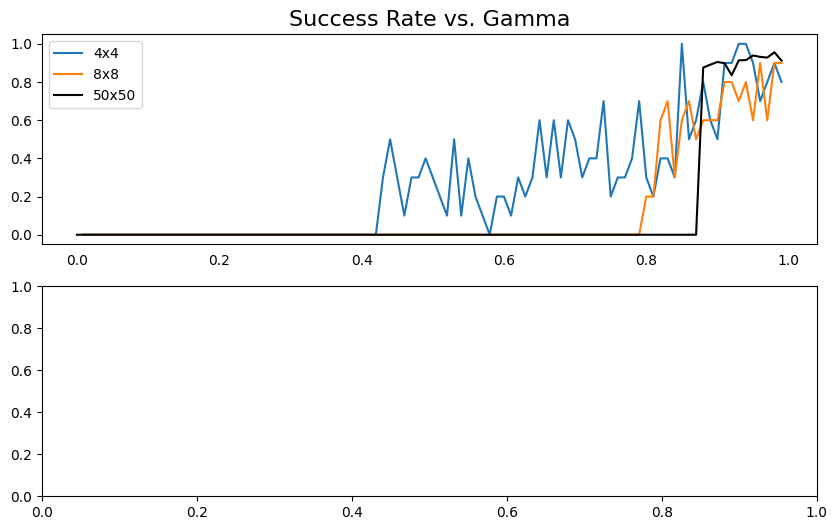

In [31]:
f, ax = plt.subplots(2, figsize=(10,6))
ax[0].set_title("Success Rate vs. Gamma", fontsize=16)
print(len(gammas))
ax[0].plot(gammas, success_rates4, label="4x4")
ax[0].tick_params(bottom=False)
ax[0].plot(gammas, success_rates8, label="8x8")
ax[0].plot(gammas50, success_rates50, label="50x50", color='k')
ax[0].legend()


# 3. Policy Iteration

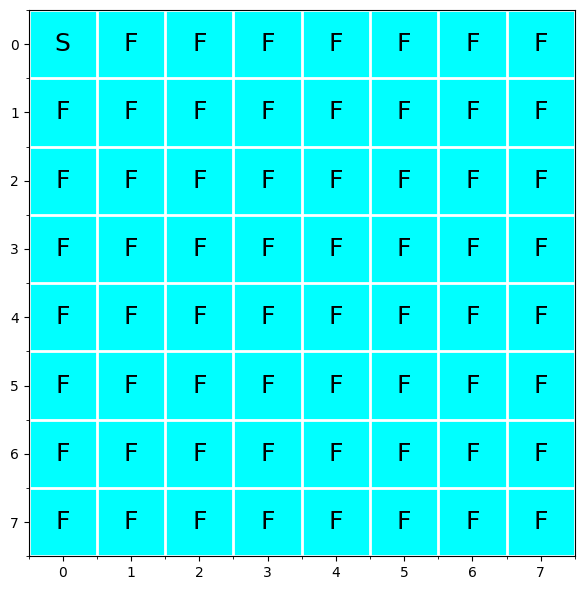

StochasticError: 'PyMDPToolbox - The transition probability matrix is not stochastic.'

In [4]:
s = 50
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v0", map_name=None, desc=None)
env.reset()
visualize_env(env, opt)
r, p = getRewardProb(env, s)
import time

tic = time.time()
vi1 = mdp.PolicyIteration(p, r, 0.999, max_iter=100)
vi1.run()
print(time.time()-tic)

tic = time.time()
vi2 = mdp.ValueIteration(p, r, 0.999, max_iter=5000)
vi2.run()
print(time.time()-tic)

visualize_policy(vi1.policy, sz, opt)
visualize_policy(vi2.policy, sz, opt)

In [32]:
print("Policies match {}%".format(100*(np.array(vi1.policy) == np.array(vi2.policy)).sum()/np.array(vi1.policy).shape[0]))

Policies match 98.2%


In [5]:
env = gym.make("FrozenLake-v0", is_slippery=True, map_name=None, desc=None)
r, p = getRewardProb(env,50)
valueIterateGraph(p, r)

NameError: name 'valueIterateGraph' is not defined

[0.5, 0.54, 0.5800000000000001, 0.6200000000000001, 0.6600000000000001, 0.7000000000000002, 0.7400000000000002, 0.7800000000000002, 0.8200000000000003, 0.8600000000000003, 0.9000000000000004, 0.9400000000000004, 0.9800000000000004]
93.05813908576965


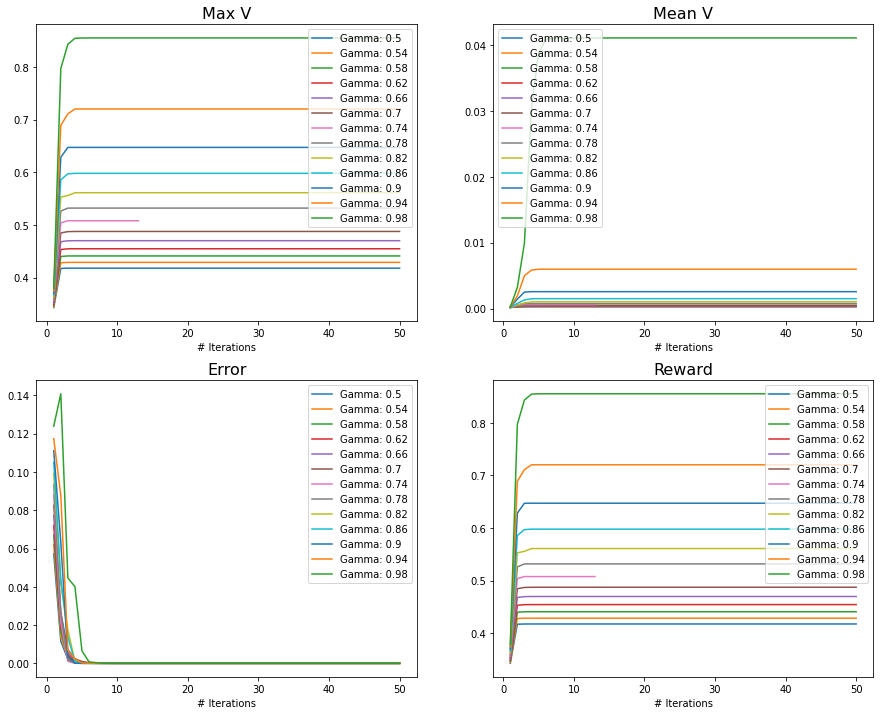

In [82]:
from time import time
tic = time()
env = gym.make("FrozenLake-v0", is_slippery=True, map_name=None, desc=None)
r, p = getRewardProb(env,50)
valueIterateGraph(p, r, False)
print(time()-tic)

## 4. Q Learning 

11.123210191726685


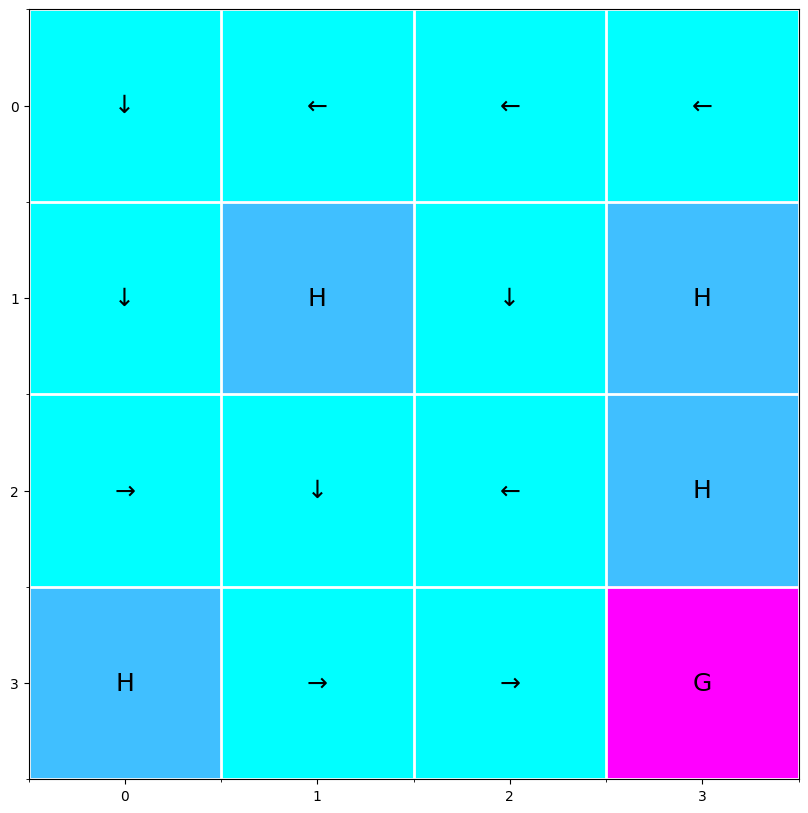

In [38]:
import time
# (self, transitions, reward, gamma,
#                  alpha=0.1, alpha_decay=0.99, alpha_min=0.001,
#                  epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.99,
#                  n_iter=10000, skip_check=False, iter_callback=None,
#                  run_stat_frequency=None)

s = 4
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v0", map_name="4x4", is_slippery=False)
env.reset()
r, p = getRewardProb(env, s)

tic = time.time()
# vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.999, epsilon=1, epsilon_decay=0.99, n_iter=100000)
vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.99999, epsilon=1, epsilon_decay=0.9999, n_iter=1000000)
vi2.run()
print(time.time()-tic)

visualize_policy(vi2.policy, sz, opt)

178.81369519233704


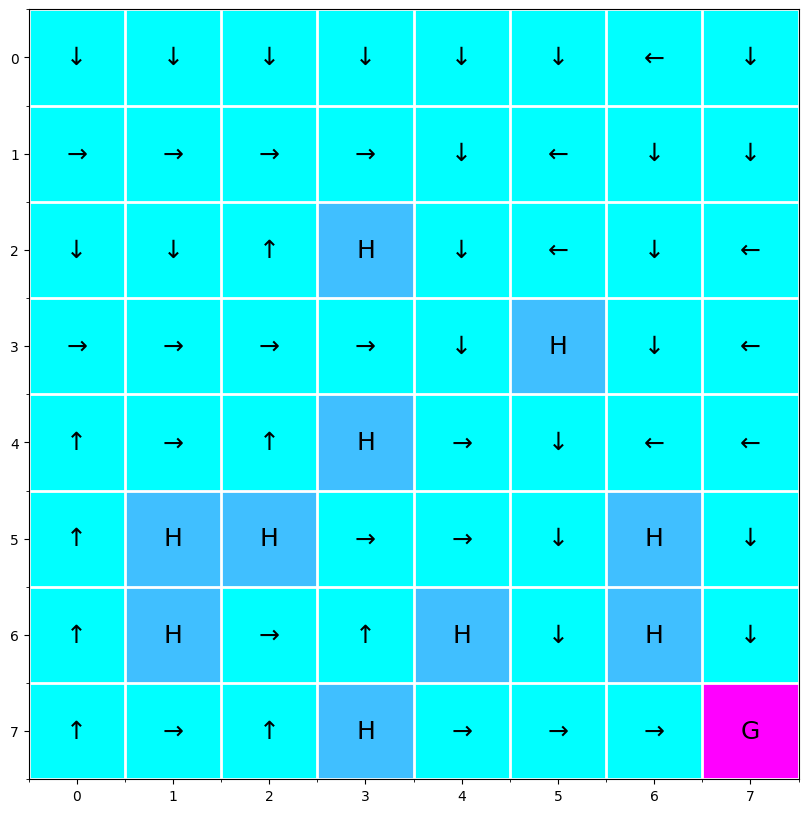

In [35]:
s = 8
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v0", map_name="8x8", is_slippery=False)
env.reset()
r, p = getRewardProb(env, s)

tic = time.time()
# vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.999, epsilon=1, epsilon_decay=0.99, n_iter=100000)
vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.99999, epsilon=.2, epsilon_decay=0.9999, n_iter=10000000)
vi2.run()
print(time.time()-tic)

visualize_policy(vi2.policy, sz, opt)

In [39]:
s = 50
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v0", map_name="50x50", is_slippery=False, desc=None)
env.reset()
r, p = getRewardProb(env, s)

tic = time.time()
# vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.999, epsilon=1, epsilon_decay=0.99, n_iter=100000)
vi2 = mdp.QLearning(p, r, gamma=0.999, alpha=0.1, alpha_decay=0.99999, epsilon=1, epsilon_decay=0.9999, n_iter=5000000)
vi2.run()
print(time.time()-tic)

visualize_policy(vi2.policy, sz, opt)

KeyError: '50x50'

In [57]:
def QLearnGraphGammas(p, r):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    iterations = []
    gammas = [0.5, 0.9, 0.95]
    for gamma in gammas:
        vi = mdp.QLearning(p, r, gamma=gamma, alpha=0.1, alpha_decay=0.99999, epsilon=1, epsilon_decay=0.9999, n_iter=1000000)
        vi.run()
        vi.run_stats
        iterations.append(list(range(1,len(vi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in vi.run_stats])
        mean_vs.append([el['Mean V'] for el in vi.run_stats])
        errors.append([el['Error'] for el in vi.run_stats])
        rewards.append([el['Reward'] for el in vi.run_stats])
    print("small finish")
    f, ax = plt.subplots(2,2, figsize=(15,12))
    ax[0][0].set_title("Max V", fontsize=16)
    for i in range(len(max_vs)):
        ax[0][0].plot(iterations[i], max_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][0].legend()
    ax[0][0].set_xlabel("# Iterations")

    ax[0][1].set_title("Mean V", fontsize=16)
    for i in range(len(mean_vs)):
        ax[0][1].plot(iterations[i], mean_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][1].legend()
    ax[0][1].set_xlabel("# Iterations")

    ax[1][0].set_title("Error", fontsize=16)
    for i in range(len(errors)):
        ax[1][0].plot(iterations[i], errors[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][0].legend()
    ax[1][0].set_xlabel("# Iterations")

    ax[1][1].set_title("Reward", fontsize=16)
    for i in range(len(max_vs)):
        ax[1][1].plot(iterations[i], rewards[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][1].legend()
    ax[1][1].set_xlabel("# Iterations")
    plt.plot()
    
def QLearnGraphEpsilons(p, r):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    iterations = []
    epsilons = [0, 0.4, 0.8, 1]
    for epsilon in epsilons:
        vi = mdp.QLearning(p, r, gamma=0.9, alpha=0.1, alpha_decay=0.99999, epsilon=epsilon, epsilon_decay=0.9999, n_iter=1000000)
        vi.run()
        vi.run_stats
        iterations.append(list(range(1,len(vi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in vi.run_stats])
        mean_vs.append([el['Mean V'] for el in vi.run_stats])
        errors.append([el['Error'] for el in vi.run_stats])
        rewards.append([el['Reward'] for el in vi.run_stats])

    f, ax = plt.subplots(2,2, figsize=(15,12))
    ax[0][0].set_title("Max V", fontsize=16)
    for i in range(len(max_vs)):
        ax[0][0].plot(iterations[i], max_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][0].legend()
    ax[0][0].set_xlabel("# Iterations")

    ax[0][1].set_title("Mean V", fontsize=16)
    for i in range(len(mean_vs)):
        ax[0][1].plot(iterations[i], mean_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][1].legend()
    ax[0][1].set_xlabel("# Iterations")

    ax[1][0].set_title("Error", fontsize=16)
    for i in range(len(errors)):
        ax[1][0].plot(iterations[i], errors[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][0].legend()
    ax[1][0].set_xlabel("# Iterations")

    ax[1][1].set_title("Reward", fontsize=16)
    for i in range(len(max_vs)):
        ax[1][1].plot(iterations[i], rewards[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][1].legend()
    ax[1][1].set_xlabel("# Iterations")
    plt.plot()

finish get reward prob
small finish
finish graph gammas


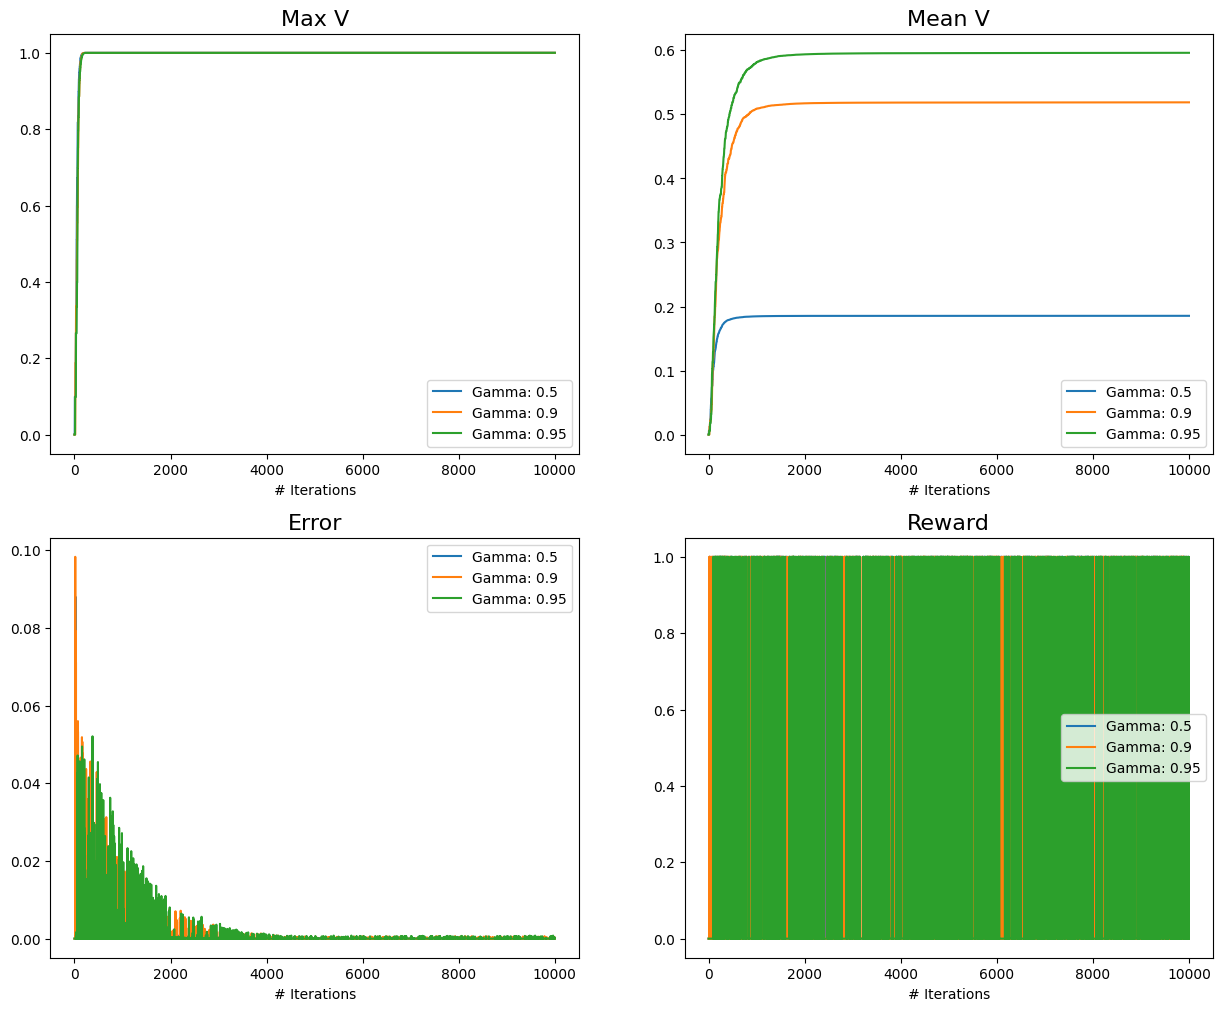

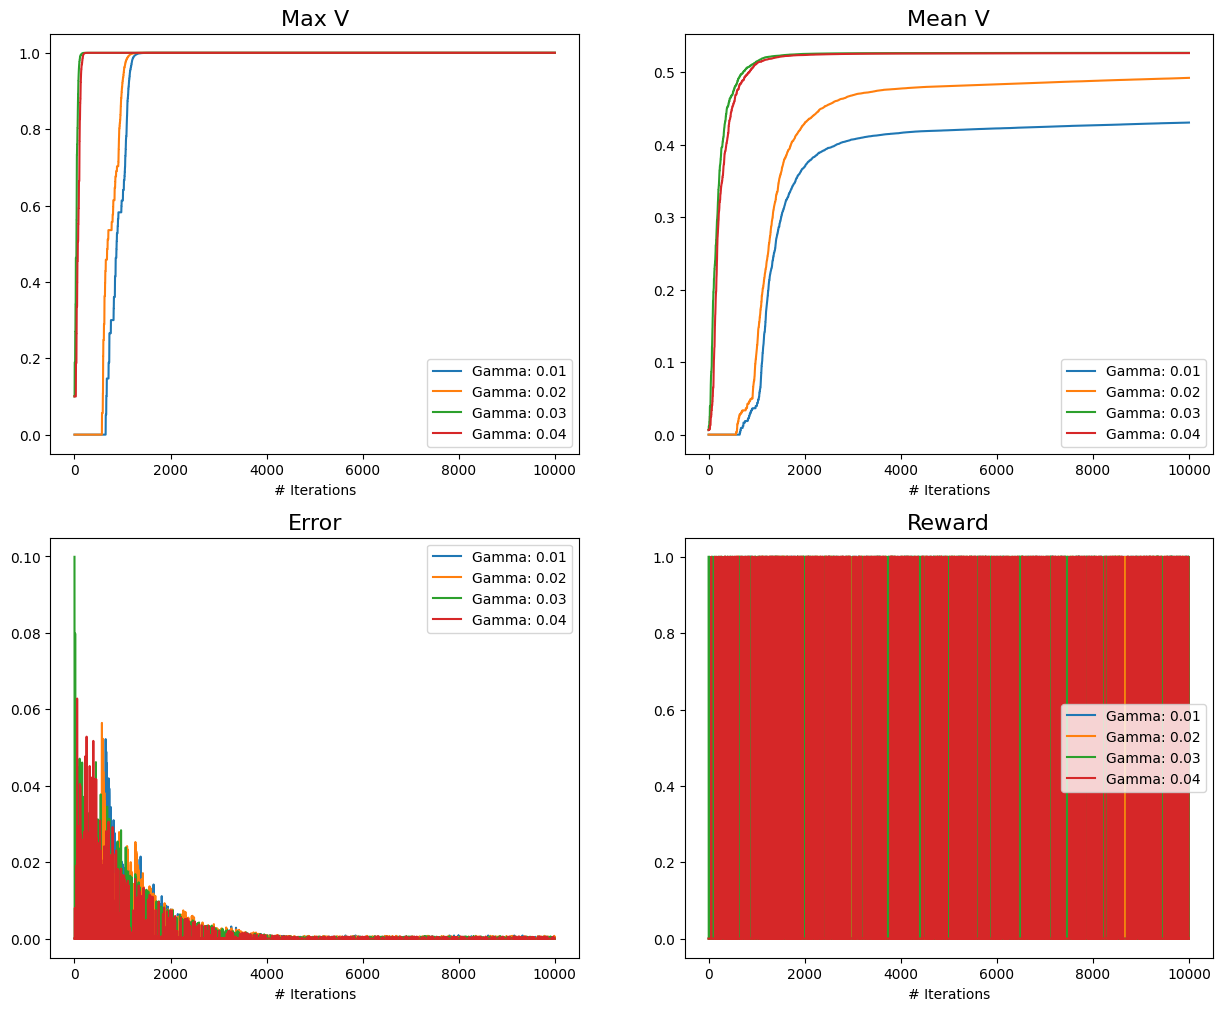

In [58]:
s = 8
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v0", map_name="8x8", is_slippery=False)
env.reset()
r, p = getRewardProb(env, s)
print("finish get reward prob")
QLearnGraphGammas(p, r)
print("finish graph gammas")
QLearnGraphEpsilons(p, r)

In [43]:
import numpy as np
import random

# Define the Frozen Forest environment
grid_size_1 = 4
grid_size_2 = 50

# Reward matrix for the Frozen Forest environment
reward_1 = np.array([[-1, -1, -1, -1],
                    [-1,  0, -1, 10],
                    [-1, -1, -1, -1],
                    [-1, -1, -1,  5]])

reward_2 = np.random.rand(grid_size_2, grid_size_2)

# Q-learning algorithm
def q_learning(reward_matrix, grid_size):
    num_states = grid_size**2
    num_actions = 4  # Up, Down, Left, Right

    # Initialize Q-values to zeros
    Q = np.zeros((num_states, num_actions))

    # Set hyperparameters
    learning_rate = 0.1
    discount_factor = 0.9
    exploration_rate = 0.1
    num_episodes = 1000

    # Q-learning algorithm
    for episode in range(num_episodes):
        state = random.randint(0, num_states - 1)  # Start from a random state

        # Run episode until reaching the goal state
        while True:
            # Choose an action using the epsilon-greedy strategy
            if random.uniform(0, 1) < exploration_rate:
                action = random.randint(0, num_actions - 1)  # Explore
            else:
                action = np.argmax(Q[state])  # Exploit

            # Perform the action and observe the next state and reward
            if action == 0:  # Up
                next_state = state - grid_size if state - grid_size >= 0 else state
            elif action == 1:  # Down
                next_state = state + grid_size if state + grid_size < num_states else state
            elif action == 2:  # Left
                next_state = state - 1 if state % grid_size != 0 else state
            elif action == 3:  # Right
                next_state = state + 1 if (state + 1) % grid_size != 0 else state

            reward = reward_matrix[state // grid_size, state % grid_size]

            # Update Q-value using the Bellman equation
            Q[state, action] += learning_rate * (reward + discount_factor * np.max(Q[next_state]) - Q[state, action])

            state = next_state

            # Break if the goal state is reached
            if state == num_states - 1:
                break

    return Q

# Run Q-learning for the Frozen Forest with a 4x4 grid
Q_1 = q_learning(reward_1, grid_size_1)
min_value_1 = np.min(Q_1)
max_value_1 = np.max(Q_1)

# Run Q-learning for the Frozen Forest with a 50x50 grid
Q_2 = q_learning(reward_2, grid_size_2)
min_value_2 = np.min(Q_2)
max_value_2 = np.max(Q_2)

# Print the results
print("Results for Frozen Forest (4x4):")
print("Min Q-value:", min_value_1)
print("Max Q-value:", max_value_1)
print()
print("Results for Frozen Forest (50x50):")
print("Min Q-value:", min_value_2)
print("Max Q-value:", max_value_2)

KeyboardInterrupt: 